In [2]:
import pandas as pd
import os
from datetime import datetime
import numpy as np

def read_one_user(n):
    user_path = '../Data/0'+str(n)+'/labels.txt'
    transport_df = pd.read_csv(user_path, sep="\t")
    
    directory = '../Data/0'+str(n)+'/Trajectory'
    
    gps_points_df = pd.DataFrame(columns=['time', 'lat', 'lon', 'alt', 'identifier'])
    for filename in os.listdir(directory):
        dt_object = datetime.strptime(filename[:-4], '%Y%m%d%H%M%S')
        for index, row in transport_df.iterrows():
            start = datetime.strptime(row['Start Time'],'%Y/%m/%d %H:%M:%S')
            end = datetime.strptime(row['End Time'],'%Y/%m/%d %H:%M:%S')
            if dt_object >= start and dt_object <= end:
                # turn all gps points into df
                # append to general df
                # set index as identifier
                
                file_df = pd.read_csv(directory+'/'+filename, skiprows=6, header=None,
                         parse_dates=[[5, 6]], infer_datetime_format=True)
                file_df.rename(inplace=True, columns={'5_6': 'time', 0: 'lat', 1: 'lon', 3: 'alt'})
                file_df.drop(inplace=True, columns=[2, 4])
                file_df['identifier'] = index
                gps_points_df = pd.concat([gps_points_df,file_df])
                
    return transport_df,gps_points_df

transport_df,gps_points_df = read_one_user(10)

In [3]:
transport_df

,Start Time,End Time,Transportation Mode
0,2007/06/26 11:32:29,2007/06/26 11:40:29,bus
1,2008/03/28 14:52:54,2008/03/28 15:59:59,train
2,2008/03/28 16:00:00,2008/03/28 22:02:00,train
3,2008/03/29 01:27:50,2008/03/29 15:59:59,train
4,2008/03/29 16:00:00,2008/03/30 15:59:59,train
...,...,...,...
429,2008/12/07 10:30:54,2008/12/07 10:34:14,taxi
430,2008/12/07 10:59:29,2008/12/07 11:29:48,train
431,2008/12/07 11:43:12,2008/12/07 12:23:26,bus
432,2008/12/07 12:23:34,2008/12/07 12:25:07,walk


In [4]:
gps_points_df

,time,lat,lon,alt,identifier
0,2008-03-28 16:00:01,39.50293,116.714948,-777,2
1,2008-03-28 16:01:00,39.497045,116.726137,-777,2
2,2008-03-28 16:01:59,39.489695,116.740047,-777,2
3,2008-03-28 16:02:59,39.481438,116.755648,-777,2
4,2008-03-28 16:03:58,39.472748,116.770972,-777,2
...,...,...,...,...,...
3691,2008-12-07 12:37:24,39.991644,116.326376,184,427
3692,2008-12-07 12:37:25,39.991641,116.326325,180,427
3693,2008-12-07 12:37:26,39.991641,116.326289,177,427
3694,2008-12-07 12:37:27,39.991643,116.326273,174,427


In [ ]:
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point
from datetime import timedelta
import movingpandas as mpd
import matplotlib.pyplot as plt

single_traj_df = gps_points_df
# Adding a geometry column
single_traj_df['geometry'] = [Point(lon, lat) for lon, lat in 
                             zip(single_traj_df['lon'].to_list(), single_traj_df['lat'].to_list())]
# Creating a Geodataframe. Be aware it is CRS 4326 WGS84
geodata = gpd.GeoDataFrame(single_traj_df, crs = CRS.from_epsg('4326'))
geodata = geodata.set_index('time')
# Create a Trajectory Collection with Movingpandas
traj_collection = mpd.TrajectoryCollection(geodata, 'identifier')
# Define parameters in Hours and Search radius in meters
Hours = .5
SearchRadio = 1000
# stop detection
stops = mpd.TrajectoryStopDetector(traj_collection).get_stop_segments(min_duration=timedelta(hours=Hours), max_diameter=SearchRadio)
# Create a new Geodataframe and define geometry column
stops_start = gpd.GeoDataFrame(columns = ['geometry'])
stops_start = stops_start.set_geometry('geometry')

# Add the ID of each stop track and define it as index
stops_start['stop_id'] = [track.id for track in stops.trajectories]
stops_start= stops_start.set_index('stop_id')
# Iteration over the Stop Trajectories
for stoptrack in stops.trajectories:

    # add stop duration in hours
    stops_start.at[stoptrack.id,'duration_h'] =stoptrack.get_duration().total_seconds()/3600

    # add length
    stops_start.at[stoptrack.id, 'length_m']=stoptrack.get_length()

    # add bird name
    stops_start.at[stoptrack.id, 'identifier']=stoptrack.id.split('_')[0]

    # add datetime
    stops_start.at[stoptrack.id, 'datetime']= pd.to_datetime(stoptrack.id.split('_')[1]).tz_localize(None)

    # geometry with start point
    stops_start.at[stoptrack.id, 'geometry'] = stoptrack.get_start_location()
    
# Reset indexes
stops_start = stops_start.reset_index(drop=True)
geodata= geodata.reset_index(drop=True)

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\ProgramData\Miniconda3\lib\site-packages\movingpandas\geometry_utils.py:150: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(geom) == 2:
C:\ProgramData\Miniconda3\lib\site-packages\movingpandas\geometry_utils.py:151: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return _measure_distance(geom[0], geom[1], spherical)


In [ ]:
stops_start

In [ ]:
geodata

In [21]:
# from shapely import wkb

# test_wkb_stops_start = stops_start
# test_wkb = [wkb.dumps(p, hex=True, srid=4326) for p in test_wkb_stops_start['geometry'].tolist()]
# test_wkb_stops_start['geometry']=test_wkb

In [18]:
from keplergl import KeplerGl

# Create KeplerGl instance
m = KeplerGl(height=600)
# Add stop durations
m.add_data(test_wkb_stops_start, 'stops')
# Add gps records
m.add_data(geodata, 'trajectories')
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


AttributeError: 'str' object has no attribute '_geom'

In [ ]:
# try the tutorial visualizaiton

In [46]:
# import geopandas as gpd
# from pyproj import CRS
# from shapely.geometry import Point
# import movingpandas as mpd
# import matplotlib.pyplot as plt

# ids = gps_points_df['identifier'].unique()
# for i in ids[:1]:
#     single_traj_df = gps_points_df[gps_points_df['identifier']==i]
#     print('single_traj_df #######################\n',single_traj_df)
#     # Adding a geometry column
#     single_traj_df['geometry'] = [Point(lon, lat) for lon, lat in 
#                                  zip(single_traj_df['lon'].to_list(), single_traj_df['lat'].to_list())]
#     print('single_traj_df w/ geometry #######################\n',single_traj_df)
#     # Creating a Geodataframe. Be aware it is CRS 4326 WGS84
#     geodata = gpd.GeoDataFrame(single_traj_df, crs = CRS.from_epsg('4326'))
#     geodata = geodata.set_index('time')
#     print('geodata #######################\n',geodata)
#     # Create a Trajectory Collection with Movingpandas
#     traj_collection = mpd.TrajectoryCollection(geodata, 'identifier')
#     print('traj_collection #######################\n',traj_collection)
#     # Define parameters in Hours and Search radius in meters
#     Hours = .5
#     SearchRadio = 1000
#     # stop detection
#     stops = mpd.TrajectoryStopDetector(traj_collection).get_stop_segments(min_duration=timedelta(hours=Hours), max_diameter=SearchRadio)
#     print('stops #######################\n',stops)
#     # Create a new Geodataframe and define geometry column
#     stops_start = gpd.GeoDataFrame(columns = ['geometry'])
#     stops_start = stops_start.set_geometry('geometry')
    
#     # Add the ID of each stop track and define it as index
#     stops_start['stop_id'] = [track.id for track in stops.trajectories]
#     stops_start= stops_start.set_index('stop_id')
#     print('stops_start #######################\n',stops_start)
#     # Iteration over the Stop Trajectories
#     for stoptrack in stops.trajectories:

#         # add stop duration in hours
#         stops_start.at[stoptrack.id,'duration_h'] =stoptrack.get_duration().total_seconds()/3600

#         # add length
#         stops_start.at[stoptrack.id, 'length_m']=stoptrack.get_length()

#         # add bird name
#         stops_start.at[stoptrack.id, 'identifier']=stoptrack.id.split('_')[0]

#         # add datetime
#         stops_start.at[stoptrack.id, 'datetime']= pd.to_datetime(stoptrack.id.split('_')[1]).tz_localize(None)

#         # geometry with start point
#         stops_start.at[stoptrack.id, 'geometry'] = stoptrack.get_start_location()
        
#     stops = stops_start['geometry'].tolist()
#     print('stops #######################\n',stops)
#     xs = [point.x for point in stops]
#     ys = [point.y for point in stops]
#     plt.scatter(xs, ys)
#     plt.plot(xs, ys)
#     plt.title('Transport Mode:'+transport_df.at[i,'Transportation Mode'])
#     plt.show()

single_traj_df #######################
                      time        lat         lon   alt identifier
0     2008-03-28 16:00:01   39.50293  116.714948  -777          2
1     2008-03-28 16:01:00  39.497045  116.726137  -777          2
2     2008-03-28 16:01:59  39.489695  116.740047  -777          2
3     2008-03-28 16:02:59  39.481438  116.755648  -777          2
4     2008-03-28 16:03:58  39.472748  116.770972  -777          2
...                   ...        ...         ...   ...        ...
1175  2008-03-29 15:55:52   34.48202  109.682868  -777          2
1176  2008-03-29 15:56:51   34.48106   109.66749  -777          2
1177  2008-03-29 15:57:50   34.48388  109.652437  -777          2
1178  2008-03-29 15:58:49  34.485233   109.63913  -777          2
1179  2008-03-29 15:59:48  34.490502  109.629697  -777          2

[1180 rows x 5 columns]
single_traj_df w/ geometry #######################
                      time        lat         lon   alt identifier  \
0     2008-03-28 16:00

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\giova\AppData\Local\Temp\ipykernel_3980\2038789792.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_traj_df['geometry'] = [Point(lon, lat) for lon, lat in


TypeError: 'NoneType' object is not callable

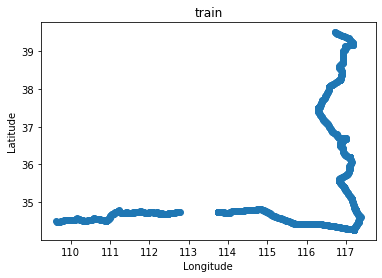

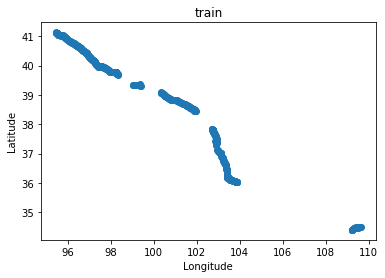

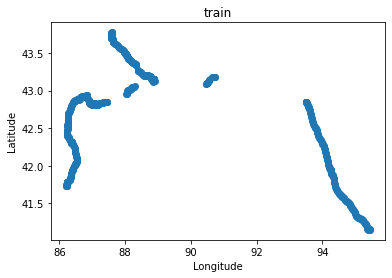

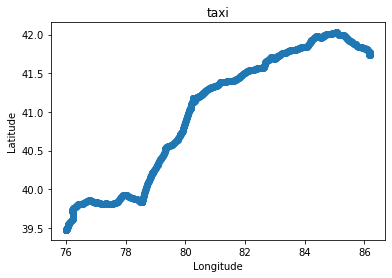

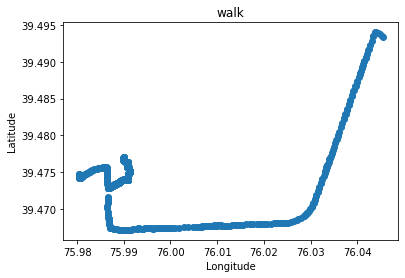

In [4]:
# import matplotlib.pyplot as plt

# def draw_motif(transport_df,gps_points_df):
#     ids = gps_points_df['identifier'].unique()
#     for i in ids[:5]:
#         single_mode_df = gps_points_df[gps_points_df['identifier']==i]
#         plt.scatter(x=single_mode_df['lon'], y=single_mode_df['lat'])
#         plt.xlabel('Longitude')
#         plt.ylabel('Latitude')
#         plt.title(transport_df.at[i,'Transportation Mode'])
#         plt.show()
        
# draw_motif(transport_df,gps_points_df)

In [5]:
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point
from datetime import timedelta

# Adding a geometry column
gps_points_df['geometry'] = [Point(lon, lat) for lon, lat in 
                             zip(gps_points_df['lon'].to_list(), gps_points_df['lat'].to_list())]

# Creating a Geodataframe. Be aware it is CRS 4326 WGS84
geodata = gpd.GeoDataFrame(gps_points_df, crs = CRS.from_epsg('4326'))
geodata = geodata.set_index('time')
geodata

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,lat,lon,alt,identifier,geometry
time,,,,,
2008-03-28 16:00:01,39.50293,116.714948,-777,2,POINT (116.71495 39.50293)
2008-03-28 16:01:00,39.497045,116.726137,-777,2,POINT (116.72614 39.49704)
2008-03-28 16:01:59,39.489695,116.740047,-777,2,POINT (116.74005 39.48969)
2008-03-28 16:02:59,39.481438,116.755648,-777,2,POINT (116.75565 39.48144)
2008-03-28 16:03:58,39.472748,116.770972,-777,2,POINT (116.77097 39.47275)
...,...,...,...,...,...
2008-12-07 12:37:24,39.991644,116.326376,184,427,POINT (116.32638 39.99164)
2008-12-07 12:37:25,39.991641,116.326325,180,427,POINT (116.32632 39.99164)
2008-12-07 12:37:26,39.991641,116.326289,177,427,POINT (116.32629 39.99164)


In [10]:
import movingpandas as mpd

# Create a Trajectory Collection with Movingpandas
traj_collection = mpd.TrajectoryCollection(geodata, 'identifier')
traj_collection

TrajectoryCollection with 83 trajectories

In [12]:
from datetime import timedelta

start = datetime.now()
print('Início em:',start)
# Define parameters in Hours and Search radius in meters
Hours = 1
SearchRadio = 500
# stop detection
stops = mpd.TrajectoryStopDetector(traj_collection).get_stop_segments(min_duration=timedelta(hours=Hours), max_diameter=SearchRadio)

end = datetime.now()
print('Tempo gasto:',end-start)

stops

C:\ProgramData\Miniconda3\lib\site-packages\movingpandas\geometry_utils.py:150: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(geom) == 2:
C:\ProgramData\Miniconda3\lib\site-packages\movingpandas\geometry_utils.py:151: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return _measure_distance(geom[0], geom[1], spherical)


Tempo gasto: 1:54:40.647456


TrajectoryCollection with 23 trajectories

In [21]:
# Create a new Geodataframe and define geometry column
stops_start = gpd.GeoDataFrame(columns = ['geometry'])
stops_start = stops_start.set_geometry('geometry')
# Add the ID of each stop track and define it as index
stops_start['stop_id'] = [track.id for track in stops.trajectories]
stops_start= stops_start.set_index('stop_id')

# Iteration over the Stop Trajectories
for stoptrack in stops.trajectories:
    
    # add stop duration in hours
    stops_start.at[stoptrack.id,'duration_h'] =stoptrack.get_duration().total_seconds()/3600
    
    # add length
    stops_start.at[stoptrack.id, 'length_m']=stoptrack.get_length()
    
    # add bird name
    stops_start.at[stoptrack.id, 'identifier']=stoptrack.id.split('_')[0]
    
    # add datetime
    stops_start.at[stoptrack.id, 'datetime']= pd.to_datetime(stoptrack.id.split('_')[1]).tz_localize(None)
    
    # geometry with start point
    stops_start.at[stoptrack.id, 'geometry'] = stoptrack.get_start_location()
    
stops_start.head()

,geometry,duration_h,length_m,identifier,datetime
stop_id,,,,,
7_2008-04-01 01:08:13,POINT (80.26465 41.17047),2.639444,244.216295,7,2008-04-01 01:08:13
18_2008-04-03 12:06:00,POINT (82.96581 41.71018),1.828333,504.918674,18,2008-04-03 12:06:00
18_2008-04-03 14:01:49,POINT (83.01363 41.69361),1.541111,511.336346,18,2008-04-03 14:01:49
24_2008-04-04 05:03:35,POINT (89.17536 42.94970),2.231944,495.200950,24,2008-04-04 05:03:35
41_2008-06-16 03:44:59,POINT (117.67296 39.02734),3.406667,1348.433927,41,2008-06-16 03:44:59


In [29]:
stops_start

,geometry,duration_h,length_m,identifier,datetime
stop_id,,,,,
7_2008-04-01 01:08:13,POINT (80.26465 41.17047),2.639444,244.216295,7,2008-04-01 01:08:13
18_2008-04-03 12:06:00,POINT (82.96581 41.71018),1.828333,504.918674,18,2008-04-03 12:06:00
18_2008-04-03 14:01:49,POINT (83.01363 41.69361),1.541111,511.336346,18,2008-04-03 14:01:49
24_2008-04-04 05:03:35,POINT (89.17536 42.94970),2.231944,495.200950,24,2008-04-04 05:03:35
41_2008-06-16 03:44:59,POINT (117.67296 39.02734),3.406667,1348.433927,41,2008-06-16 03:44:59
65_2008-06-18 13:37:24,POINT (116.47484 39.92602),1.016944,1029.520425,65,2008-06-18 13:37:24
75_2008-06-19 10:35:28,POINT (118.38397 31.34890),2.285556,608.563084,75,2008-06-19 10:35:28
77_2008-06-20 08:54:57,POINT (116.58031 38.05848),2.003056,526.458291,77,2008-06-20 08:54:57
85_2008-06-28 07:36:07,POINT (117.18519 39.08719),4.943333,625.350635,85,2008-06-28 07:36:07


In [31]:
import matplotlib.pyplot as plt

def draw_motif(stops_start):
    stops = stops_start['geometry'].tolist()
    ids = stops_start['identifier'].tolist()
    xs = [point.x for point in stops]
    ys = [point.y for point in stops]
    plt.scatter(xs, ys)
    plt.plot(xs, ys)
    plt.title('Transpor Mode:',transport_df.at[i,'Transportation Mode'])
    plt.show()
        
draw_motif(stops_start)

KeyError: 'identifier'